# LuxonisDatasetFormat - testing embeddings methods

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.onnx
import onnx
import onnxruntime

from qdrant_client import QdrantClient
from qdrant_client.models import Distance

from luxonis_ml.data.dataset import HType, IType, LDFComponent, LuxonisDataset, BucketStorage

from luxonis_ml.embeddings.data_utils import *
from luxonis_ml.embeddings.model_utils import *
from luxonis_ml.embeddings.embedding_utils import *
from luxonis_ml.embeddings.qdrant_utils import *
from luxonis_ml.embeddings.ldf_emb import *

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch examples

In [2]:
# Load the data
data_loader = load_mnist_data(save_path='./mnist', num_samples=640, batch_size=64)

In [3]:

# Load the model
model = load_model_resnet50_minuslastlayer()

In [4]:

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [5]:

save_embeddings(embeddings, labels)

## ONNX models and Qdrant

In [6]:
# Load the data
data_loader = load_mnist_data(save_path='./mnist', num_samples=640, batch_size=64)

In [7]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(onnx_model, intermediate_tensor_name="/Flatten_output_0")

# Save the ONNX model
onnx.save(onnx_model, "resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = ['CUDAExecutionProvider'] if torch.cuda.is_available() and 'CUDAExecutionProvider' in onnxruntime.get_available_providers() else None
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(ort_session, data_loader)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels)

In [9]:
embeddings, labels = load_embeddings()

In [10]:
# Connect to Qdrant
client = connect_to_qdrant()

# Create a collection
vector_size = embeddings.shape[1]
create_collection(client, collection_name="mnist2", vector_size=vector_size, distance=Distance.COSINE)

# Insert the embeddings into the collection
# insert_embeddings(client, embeddings, labels, collection_name="mnist2")
# insert_embeddings_nooverwrite(client, embeddings, labels, collection_name="mnist2")
batch_insert_embeddings_nooverwrite(client, embeddings, labels, batch_size=50, collection_name="mnist2")

Inserted 50 new embeddings for batch 0-50
Inserted 50 new embeddings for batch 50-100
Inserted 50 new embeddings for batch 100-150
Inserted 50 new embeddings for batch 150-200
Inserted 50 new embeddings for batch 200-250
Inserted 50 new embeddings for batch 250-300
Inserted 50 new embeddings for batch 300-350
Inserted 50 new embeddings for batch 350-400
Inserted 50 new embeddings for batch 400-450
Inserted 50 new embeddings for batch 450-500
Inserted 50 new embeddings for batch 500-550
Inserted 50 new embeddings for batch 550-600
Inserted 40 new embeddings for batch 600-640


In [11]:
# Search for the nearest neighbors
search_results = search_embeddings(client, embeddings[0], collection_name="mnist2", top=5)

# Print the search results
print(np.array(search_results))

[ScoredPoint(id=1, version=0, score=1.0, payload={'label': 1}, vector=None)
 ScoredPoint(id=457, version=9, score=0.98755455, payload={'label': 1}, vector=None)
 ScoredPoint(id=640, version=12, score=0.98747563, payload={'label': 1}, vector=None)
 ScoredPoint(id=409, version=8, score=0.98471886, payload={'label': 1}, vector=None)
 ScoredPoint(id=17, version=0, score=0.98461306, payload={'label': 1}, vector=None)]


## LuxonisDatasetFormat, ONNX and Qdrant

In [12]:
def train_test_val_split(NUM_SAMPLES, train=0.8, val=0.1, test=0.1, seed=42):
    if train + val + test != 1.0:
        raise ValueError("TRAIN + VAL + TEST must equal 1.0")
    
    np.random.seed(seed)
    # generate random indices for train, val, test splits
    indices = np.random.permutation(NUM_SAMPLES)
    train_indices, val_indices, test_indices = indices[:int(train * NUM_SAMPLES)], indices[int(train * NUM_SAMPLES):int((train + val) * NUM_SAMPLES)], indices[int((train + val) * NUM_SAMPLES):]
    train_test_val = np.array(["train"]*NUM_SAMPLES)
    train_test_val[train_indices] = "train"
    train_test_val[val_indices] = "val"
    train_test_val[test_indices] = "test"

    return train_test_val


In [13]:
BUCKET_STORAGE = BucketStorage.LOCAL
NUM_SAMPLES = 6400 #-1 # minus one is equivalent to all samples
BATCH_SIZE = 64
TRAIN,VAL,TEST = 0.8,0.1,0.1

In [14]:

# Load the MNIST data
data_loader = load_mnist_data(save_path='./mnist', num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")


Number of samples: 6400


In [15]:

# Split the data into train, val, test
train_test_val = train_test_val_split(NUM_SAMPLES, train=TRAIN, val=VAL, test=TEST)


In [16]:
# Create a tmp directory to store the images
mnist_image_dir = './mnist_images'
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)


In [17]:

# Convert MNIST data to Luxonis ML format
additions = []
batch_num = 0
for batch in data_loader:
    images, labels = batch
    for i, (image, label) in enumerate(zip(images, labels)):
        img_ix = batch_num*BATCH_SIZE + i
        
        # Save image to disk
        image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
        torchvision.utils.save_image(image, image_path)
        
        # Create dictionary structure for Luxonis ML
        additions.append({
            'image': {
                'filepath': image_path,
                'split': train_test_val[img_ix],
                'class': str(label.item())
            }
        })
    batch_num += 1

# original_additions = deepcopy(additions)


In [18]:

# 2. Load the MNIST Data into LDF
team_id = "luxonis_id"
team_name = "luxonis_team"
dataset_name = "mnist_dataset"

# Create a new dataset in LDF
dataset_id = LuxonisDataset.create(
    team_id=team_id,
    team_name=team_name,
    dataset_name=dataset_name
)

print(f"Dataset ID: {dataset_id}")


Dataset ID: 64ef297e95832b6397cd6acd


In [19]:

# Add the MNIST data to the dataset
with LuxonisDataset(
    team_id=team_id,
    dataset_id=dataset_id,
    team_name=team_name,
    dataset_name=dataset_name,
    bucket_storage=BUCKET_STORAGE
) as dataset:
    dataset.create_source(
        'mnist',
        custom_components=[
            LDFComponent('image', HType.IMAGE, IType.BGR)
        ]
    )
    dataset.set_classes(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    dataset.add(additions)
    dataset.create_version(note="Adding MNIST data")


2023-08-30 11:35:26,291 [INFO] Checking for additions or modifications...
  9%|▉         | 570/6400 [00:00<00:03, 1919.95it/s]

100%|██████████| 6400/6400 [00:03<00:00, 1835.71it/s]
2023-08-30 11:35:29,783 [INFO] Extracting dataset media...
100%|██████████| 6400/6400 [11:44<00:00,  9.08it/s]
2023-08-30 11:47:14,251 [INFO] Executing changes to dataset...
100%|██████████| 6401/6401 [00:03<00:00, 1704.81it/s]
2023-08-30 11:47:18,045 [INFO] Adding samples to Fiftyone


 100% |███████████████| 6400/6400 [3.1s elapsed, 0s remaining, 2.1K samples/s]      


2023-08-30 11:47:21,177 [INFO]  100% |███████████████| 6400/6400 [3.1s elapsed, 0s remaining, 2.1K samples/s]      
2023-08-30 11:47:21,208 [INFO] Creating new version...
100%|██████████| 6401/6401 [01:37<00:00, 65.73it/s]


<Sample: {
    'id': '64ef2c4695832b6397cdb5d1',
    'media_type': 'image',
    'filepath': '/luxonis_id01/datasets/64ef297e95832b6397cd6acd/image/6ac73d78-80d5-5178-aa81-02c4cac07294.jpg',
    'tags': [],
    'metadata': None,
    'mnist': <Group: {'id': '64ef297e95832b6397cd6ad0', 'name': 'image'}>,
    'version': 1.0,
    'latest': True,
    'split': 'train',
    'class': <Classifications: {
        'classifications': [
            <Classification: {
                'id': '64ef2c4295832b6397cd9cd1',
                'tags': [],
                'label': '7',
                'confidence': None,
                'logits': None,
            }>,
        ],
        'logits': None,
    }>,
    'instance_id': '6ac73d78-80d5-5178-aa81-02c4cac07294',
    'tid': '64ef297e95832b6397cd6ad1',
}>


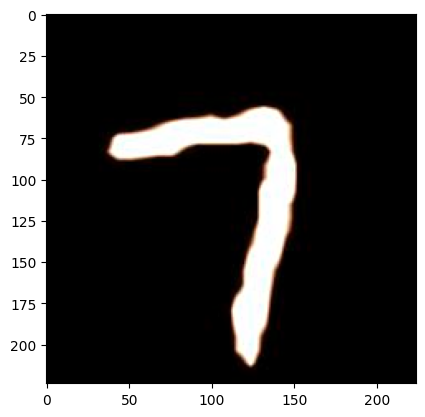

In [20]:
from matplotlib import pyplot as plt

with LuxonisDataset(    
    team_id=team_id,
    dataset_id=dataset_id
) as dataset:
    
    for sample in dataset.fo_dataset:
        # img_path = f"{str(Path.home())}/.cache/luxonis_ml/data/{sample.filepath}"
        print(sample)
        id_sub = dataset.path.split('/')[-1]
        img_rel_path = sample.filepath.split(id_sub)[-1]
        img_path = dataset.path + img_rel_path

        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.show()
        break
    

In [21]:

# Initialize the ONNX Runtime session for the model
provider = ['CUDAExecutionProvider'] if torch.cuda.is_available() and 'CUDAExecutionProvider' in onnxruntime.get_available_providers() else None
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)


In [25]:

# Start the Qdrant Docker container
# start_docker_qdrant()

# Initialize the Qdrant client
qdrant_client = connect_to_qdrant()
create_collection(qdrant_client, collection_name="mnist3", vector_size=2048, distance=Distance.COSINE)


2023-08-30 11:52:27,055 [INFO] HTTP Request: GET http://localhost:6333/collections/mnist01 "HTTP/1.1 404 Not Found"
2023-08-30 11:52:27,058 [INFO] HTTP Request: DELETE http://localhost:6333/collections/mnist01 "HTTP/1.1 200 OK"
2023-08-30 11:52:27,148 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01 "HTTP/1.1 200 OK"


In [26]:

# Load the LuxonisDataset
with LuxonisDataset(team_id=team_id, dataset_id=dataset_id) as dataset:
    # Call the _generate_embeddings method
    emb_dict = generate_embeddings(dataset, ort_session, qdrant_client, 
                        qdrant_collection_name="mnist3", 
                        output_layer_name="/Flatten_output_0")


2023-08-30 11:52:38,345 [INFO] HTTP Request: POST http://localhost:6333/collections/mnist01/points "HTTP/1.1 200 OK"
2023-08-30 11:52:53,629 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:53,677 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:53,723 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:53,765 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:53,811 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 1 / 101 of size 64 to Qdrant.
Upserted batch 2 / 101 of size 64 to Qdrant.
Upserted batch 3 / 101 of size 64 to Qdrant.
Upserted batch 4 / 101 of size 64 to Qdrant.
Upserted batch 5 / 101 of size 64 to Qdrant.


2023-08-30 11:52:53,941 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:53,985 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,026 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,064 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,105 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,146 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 6 / 101 of size 64 to Qdrant.
Upserted batch 7 / 101 of size 64 to Qdrant.
Upserted batch 8 / 101 of size 64 to Qdrant.
Upserted batch 9 / 101 of size 64 to Qdrant.
Upserted batch 10 / 101 of size 64 to Qdrant.
Upserted batch 11 / 101 of size 64 to Qdrant.


2023-08-30 11:52:54,188 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,227 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,268 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,307 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,348 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,389 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 12 / 101 of size 64 to Qdrant.
Upserted batch 13 / 101 of size 64 to Qdrant.
Upserted batch 14 / 101 of size 64 to Qdrant.
Upserted batch 15 / 101 of size 64 to Qdrant.
Upserted batch 16 / 101 of size 64 to Qdrant.
Upserted batch 17 / 101 of size 64 to Qdrant.


2023-08-30 11:52:54,434 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,476 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,512 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,550 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,591 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,632 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 18 / 101 of size 64 to Qdrant.
Upserted batch 19 / 101 of size 64 to Qdrant.
Upserted batch 20 / 101 of size 64 to Qdrant.
Upserted batch 21 / 101 of size 64 to Qdrant.
Upserted batch 22 / 101 of size 64 to Qdrant.
Upserted batch 23 / 101 of size 64 to Qdrant.


2023-08-30 11:52:54,672 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,708 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,750 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,790 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,832 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,875 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 24 / 101 of size 64 to Qdrant.
Upserted batch 25 / 101 of size 64 to Qdrant.
Upserted batch 26 / 101 of size 64 to Qdrant.
Upserted batch 27 / 101 of size 64 to Qdrant.
Upserted batch 28 / 101 of size 64 to Qdrant.
Upserted batch 29 / 101 of size 64 to Qdrant.


2023-08-30 11:52:54,918 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:54,965 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,006 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,043 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,081 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,119 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 30 / 101 of size 64 to Qdrant.
Upserted batch 31 / 101 of size 64 to Qdrant.
Upserted batch 32 / 101 of size 64 to Qdrant.
Upserted batch 33 / 101 of size 64 to Qdrant.
Upserted batch 34 / 101 of size 64 to Qdrant.
Upserted batch 35 / 101 of size 64 to Qdrant.


2023-08-30 11:52:55,165 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,211 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,254 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,292 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,334 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 36 / 101 of size 64 to Qdrant.
Upserted batch 37 / 101 of size 64 to Qdrant.
Upserted batch 38 / 101 of size 64 to Qdrant.
Upserted batch 39 / 101 of size 64 to Qdrant.
Upserted batch 40 / 101 of size 64 to Qdrant.


2023-08-30 11:52:55,375 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,415 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,457 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,495 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,538 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,579 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 41 / 101 of size 64 to Qdrant.
Upserted batch 42 / 101 of size 64 to Qdrant.
Upserted batch 43 / 101 of size 64 to Qdrant.
Upserted batch 44 / 101 of size 64 to Qdrant.
Upserted batch 45 / 101 of size 64 to Qdrant.
Upserted batch 46 / 101 of size 64 to Qdrant.


2023-08-30 11:52:55,618 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,656 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,698 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,737 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,777 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,816 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 47 / 101 of size 64 to Qdrant.
Upserted batch 48 / 101 of size 64 to Qdrant.
Upserted batch 49 / 101 of size 64 to Qdrant.
Upserted batch 50 / 101 of size 64 to Qdrant.
Upserted batch 51 / 101 of size 64 to Qdrant.
Upserted batch 52 / 101 of size 64 to Qdrant.


2023-08-30 11:52:55,865 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,913 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,952 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:55,994 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,034 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,073 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 53 / 101 of size 64 to Qdrant.
Upserted batch 54 / 101 of size 64 to Qdrant.
Upserted batch 55 / 101 of size 64 to Qdrant.
Upserted batch 56 / 101 of size 64 to Qdrant.
Upserted batch 57 / 101 of size 64 to Qdrant.
Upserted batch 58 / 101 of size 64 to Qdrant.


2023-08-30 11:52:56,112 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,151 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,192 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,232 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,273 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,315 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 59 / 101 of size 64 to Qdrant.
Upserted batch 60 / 101 of size 64 to Qdrant.
Upserted batch 61 / 101 of size 64 to Qdrant.
Upserted batch 62 / 101 of size 64 to Qdrant.
Upserted batch 63 / 101 of size 64 to Qdrant.
Upserted batch 64 / 101 of size 64 to Qdrant.


2023-08-30 11:52:56,360 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,398 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,438 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,481 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,519 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,561 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 65 / 101 of size 64 to Qdrant.
Upserted batch 66 / 101 of size 64 to Qdrant.
Upserted batch 67 / 101 of size 64 to Qdrant.
Upserted batch 68 / 101 of size 64 to Qdrant.
Upserted batch 69 / 101 of size 64 to Qdrant.
Upserted batch 70 / 101 of size 64 to Qdrant.


2023-08-30 11:52:56,604 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,644 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,687 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,727 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,769 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,806 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 71 / 101 of size 64 to Qdrant.
Upserted batch 72 / 101 of size 64 to Qdrant.
Upserted batch 73 / 101 of size 64 to Qdrant.
Upserted batch 74 / 101 of size 64 to Qdrant.
Upserted batch 75 / 101 of size 64 to Qdrant.
Upserted batch 76 / 101 of size 64 to Qdrant.


2023-08-30 11:52:56,846 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,888 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,931 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:56,970 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,018 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,057 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 77 / 101 of size 64 to Qdrant.
Upserted batch 78 / 101 of size 64 to Qdrant.
Upserted batch 79 / 101 of size 64 to Qdrant.
Upserted batch 80 / 101 of size 64 to Qdrant.
Upserted batch 81 / 101 of size 64 to Qdrant.
Upserted batch 82 / 101 of size 64 to Qdrant.


2023-08-30 11:52:57,094 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,133 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,172 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,219 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 83 / 101 of size 64 to Qdrant.
Upserted batch 84 / 101 of size 64 to Qdrant.
Upserted batch 85 / 101 of size 64 to Qdrant.
Upserted batch 86 / 101 of size 64 to Qdrant.


2023-08-30 11:52:57,444 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,483 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,531 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,583 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,624 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 87 / 101 of size 64 to Qdrant.
Upserted batch 88 / 101 of size 64 to Qdrant.
Upserted batch 89 / 101 of size 64 to Qdrant.
Upserted batch 90 / 101 of size 64 to Qdrant.
Upserted batch 91 / 101 of size 64 to Qdrant.


2023-08-30 11:52:57,666 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,713 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,755 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,797 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,844 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,883 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 92 / 101 of size 64 to Qdrant.
Upserted batch 93 / 101 of size 64 to Qdrant.
Upserted batch 94 / 101 of size 64 to Qdrant.
Upserted batch 95 / 101 of size 64 to Qdrant.
Upserted batch 96 / 101 of size 64 to Qdrant.
Upserted batch 97 / 101 of size 64 to Qdrant.


2023-08-30 11:52:57,922 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:57,962 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"
2023-08-30 11:52:58,002 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist01/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 98 / 101 of size 64 to Qdrant.
Upserted batch 99 / 101 of size 64 to Qdrant.
Upserted batch 100 / 101 of size 64 to Qdrant.
Embeddings generation and insertion completed!


In [27]:
first_emb = None

with LuxonisDataset(    
    team_id=team_id,
    dataset_id=dataset_id
) as dataset:
    # get a specific sample from dataset
    first_sample = list(emb_dict.keys())[0]
    first_emb = emb_dict[first_sample]
    sample_id = first_sample
    
    # sample_id = '64e758bdca1096d3483d18f4'
    sample = dataset.fo_dataset[sample_id]
    print(sample)

<Sample: {
    'id': '64ef2c4695832b6397cdb5d1',
    'media_type': 'image',
    'filepath': '/luxonis_id01/datasets/64ef297e95832b6397cd6acd/image/6ac73d78-80d5-5178-aa81-02c4cac07294.jpg',
    'tags': [],
    'metadata': None,
    'mnist': <Group: {'id': '64ef297e95832b6397cd6ad0', 'name': 'image'}>,
    'version': 1.0,
    'latest': True,
    'split': 'train',
    'class': <Classifications: {
        'classifications': [
            <Classification: {
                'id': '64ef2c4295832b6397cd9cd1',
                'tags': [],
                'label': '7',
                'confidence': None,
                'logits': None,
            }>,
        ],
        'logits': None,
    }>,
    'instance_id': '6ac73d78-80d5-5178-aa81-02c4cac07294',
    'tid': '64ef297e95832b6397cd6ad1',
}>


In [28]:
# Search for the nearest neighbors
search_results = search_embeddings(client, np.array(first_emb), collection_name="mnist3", top=5)
print(np.array(search_results))

2023-08-30 11:52:58,042 [INFO] HTTP Request: POST http://localhost:6333/collections/mnist01/points/search "HTTP/1.1 200 OK"


[ScoredPoint(id='6ac73d78-80d5-5178-aa81-02c4cac07294', version=0, score=1.0, payload={'class': '7', 'image_path': '/home/paperspace/.cache/luxonis_ml/data/luxonis_id01/datasets/64ef297e95832b6397cd6acd/image/6ac73d78-80d5-5178-aa81-02c4cac07294.jpg', 'instance_id': '6ac73d78-80d5-5178-aa81-02c4cac07294', 'sample_id': '64ef2c4695832b6397cdb5d1', 'split': 'train'}, vector=None)
 ScoredPoint(id='a2046355-dd6a-5c12-97e7-773bc8c156a2', version=23, score=0.95021254, payload={'class': '7', 'image_path': '/home/paperspace/.cache/luxonis_ml/data/luxonis_id01/datasets/64ef297e95832b6397cd6acd/image/a2046355-dd6a-5c12-97e7-773bc8c156a2.jpg', 'instance_id': 'a2046355-dd6a-5c12-97e7-773bc8c156a2', 'sample_id': '64ef2c4695832b6397cdbb98', 'split': 'train'}, vector=None)
 ScoredPoint(id='d6035bf7-87d5-58d5-a4db-c690a74118ec', version=3, score=0.94817156, payload={'class': '7', 'image_path': '/home/paperspace/.cache/luxonis_ml/data/luxonis_id01/datasets/64ef297e95832b6397cd6acd/image/d6035bf7-87d5-58

## Embeddings Processing

In [ ]:
# look at the test_emb_process.ipynb for the rest of the code

## Remove everything

In [31]:
# ! rm -rf ./mnist_images
# ! rm -rf ./mnist
# ! rm ./resnet50.onnx
# ! rm ./resnet50-1.onnx
# ! rm ./embeddings.pth
# ! rm ./labels.pth

# # # Stop the Qdrant Docker container
# # stop_docker_qdrant()

# # Delete the Qdrant collection
# qdrant_client.delete_collection(collection_name="mnist2")
# qdrant_client.delete_collection(collection_name="mnist3")

2023-08-30 12:50:10,311 [INFO] HTTP Request: DELETE http://localhost:6333/collections/mnist2 "HTTP/1.1 200 OK"


True

In [ ]:
# # Delete the Luxonis ML dataset
# with LuxonisDataset(
#     team_id=team_id,
#     dataset_id=dataset_id,
# ) as dataset:
    
#     dataset.delete_dataset()